# Topic: M33's Stream Dynamics
by Alondra Cardona

The purpose of this project is to look at the tidal debris in the form of stellar streams around M33 during the MW-M31 merger. This project will delve into the dynamics and kinematical evolution of M33's disk stars as a result of the gravitational phenomena experinced from its host galaxy merging with another galaxy similar in size. 

In [241]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm


# my modules
from ReadFile import Read
from ParticleProperties import ParticleInfo
from CenterOfMass2 import CenterOfMass
from OrbitCOM import OrbitCOM

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


import matplotlib.animation as animation


# Step 1: Find the positions and velocities of stars in M33 high resolution simulation data

Make file with position and velocity componens of all disk particles at selected times

In [347]:
def mag(vector):
    return np.sqrt(vector[0]**2+vector[1]**2+vector[2]**2)

def Particles(filename,type):
    """

    """
    # Initialize an instance of CenterOfMass class, using disk particles
    COM = CenterOfMass(filename, 2)
    #parts[i,0] = (COM.time).to_value()/1000 #time in GYR

    # call ReadFile function 
    time, total_parts, data = Read(filename) 

    # conditions for identifying data points of selected type
    if type == 1:
        index = np.where(data['type']==1) # dark matter halo particles
    elif type == 2:
        index = np.where(data['type']==2) # disk particles
    elif type == 3:
        index = np.where(data['type']==3) # bulge particles

    
    # calculate distance magnitude of selected particle
    positions = []
    velocities = []
    for i in range(len(data['x'][index])):
        pos = np.array([data['x'][index][i],data['y'][index][i],data['z'][index][i]])
        vel = np.array([data['vx'][index][i],data['vy'][index][i],data['vz'][index][i]])
        positions.append(pos)
        velocities.append(vel)

    vels = []
    for velocity in velocities:
        vels.append(mag(velocity))
     
     # Plot each particle
    x = []
    y = []
    z = []
    for position in positions:
        x.append(position[0])
        y.append(position[1])
        z.append(position[2])

    t = time.value/1000
    
    return x,y,z,vels,t


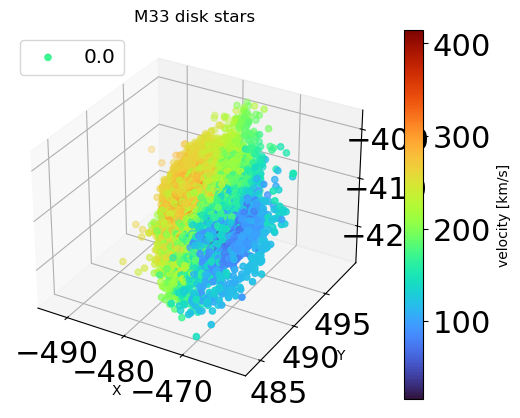

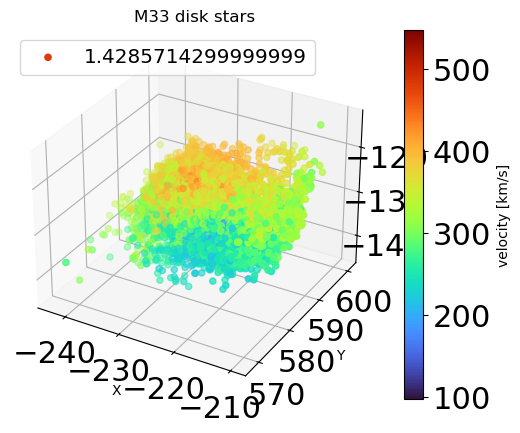

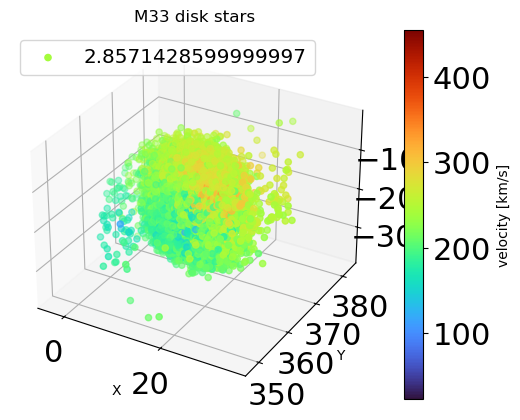

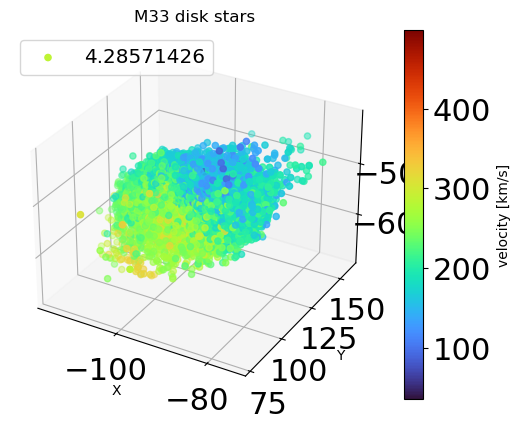

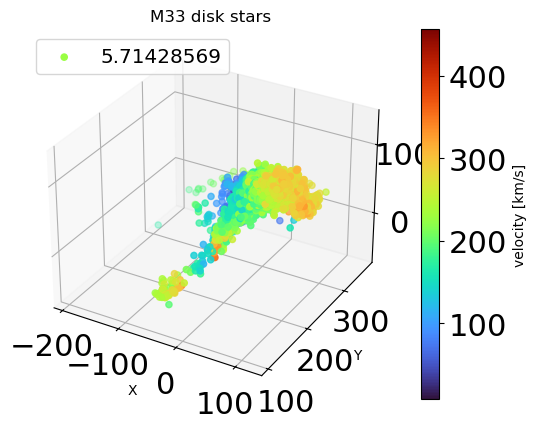

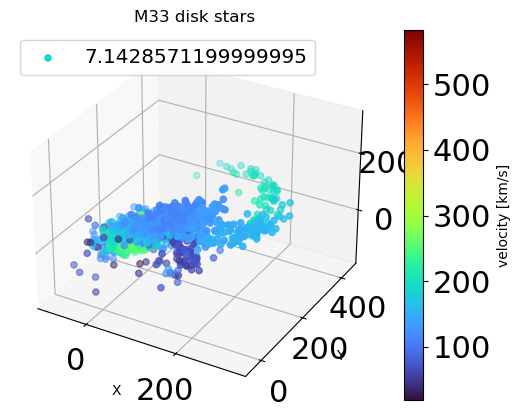

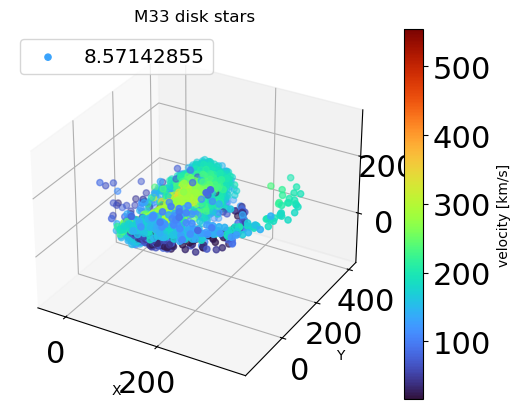

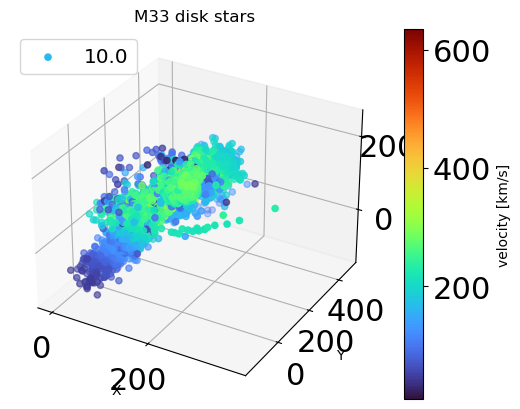

In [450]:
tsteps = np.arange(0,800,100)

for i, step in enumerate(tsteps):# loop over files
    if step < 10:
        ilbl = 'M33'+'_00'+str(step)+'.txt'
    elif step >= 10 and step < 100:
        ilbl = 'M33'+'_0'+str(step)+'.txt'
    else:
        ilbl = 'M33'+'_'+str(step)+'.txt'

    filename = 'M33'+'/'+ilbl

    x,y,z,vels,t = Particles(filename,2)

    # Create the figure and 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(x, y, z, marker='o', c=vels, cmap='turbo', label=t)

     # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper left',fontsize='x-large')
    ax.set_title('M33 disk stars')
    plt.colorbar(scatter, label='velocity [km/s]')
     
     # Show the plot
    plt.show()


# Step 2: 2D plots, color coded by velocity magnitude

In [223]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T

    return pos, vel


In [554]:
# COM instance of M33
def Positions2D(M33file):
    COMM33 = CenterOfMass(M33file,2)
    
    # Compute COM of M33 using disk particles
    COMP_33 = COMM33.COM_P(0.1,4)
    COMV_33 = COMM33.COM_V(COMP_33[0],COMP_33[1],COMP_33[2])

    # time
    t = (COMM33.time).value/1000

    # Determine positions of disk particles relative to M31 COM 
    xD = COMM33.x - COMP_33[0].value 
    yD = COMM33.y - COMP_33[1].value 
    zD = COMM33.z - COMP_33[2].value 
    
    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)
    
    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMM33.vx - COMV_33[0].value 
    vyD = COMM33.vy - COMV_33[1].value 
    vzD = COMM33.vz - COMV_33[2].value 
    
    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
    
    # Arrays for r and v 
    r = np.array([xD,yD,zD]).T # transposed 
    v = np.array([vxD,vyD,vzD]).T

    # compute the rotated position and velocity vectors
    rn, vn = RotateFrame(r,v)

    # plot
    fig, ax= plt.subplots(figsize=(12, 10))
    #plt.style.use('dark_background') # dark background

    vel = []
    for i in range(len(v)):
        vel.append(np.sqrt(v[i,0]**2+v[i,1]**2+v[i,2]**2))

    dist = []
    for i in range(len(r)):
        dist.append(r[i,0]**2+r[i,1]**2+r[i,2]**2)

    return rn, vn, dist, vel, t



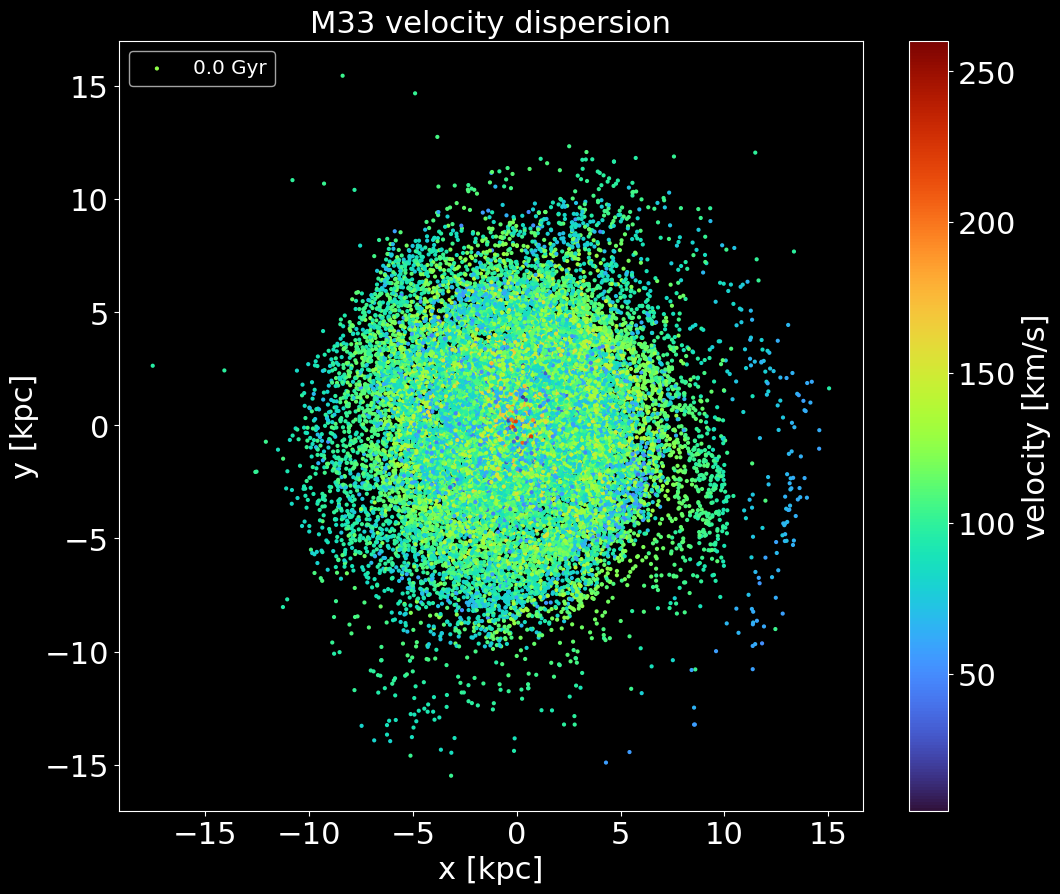

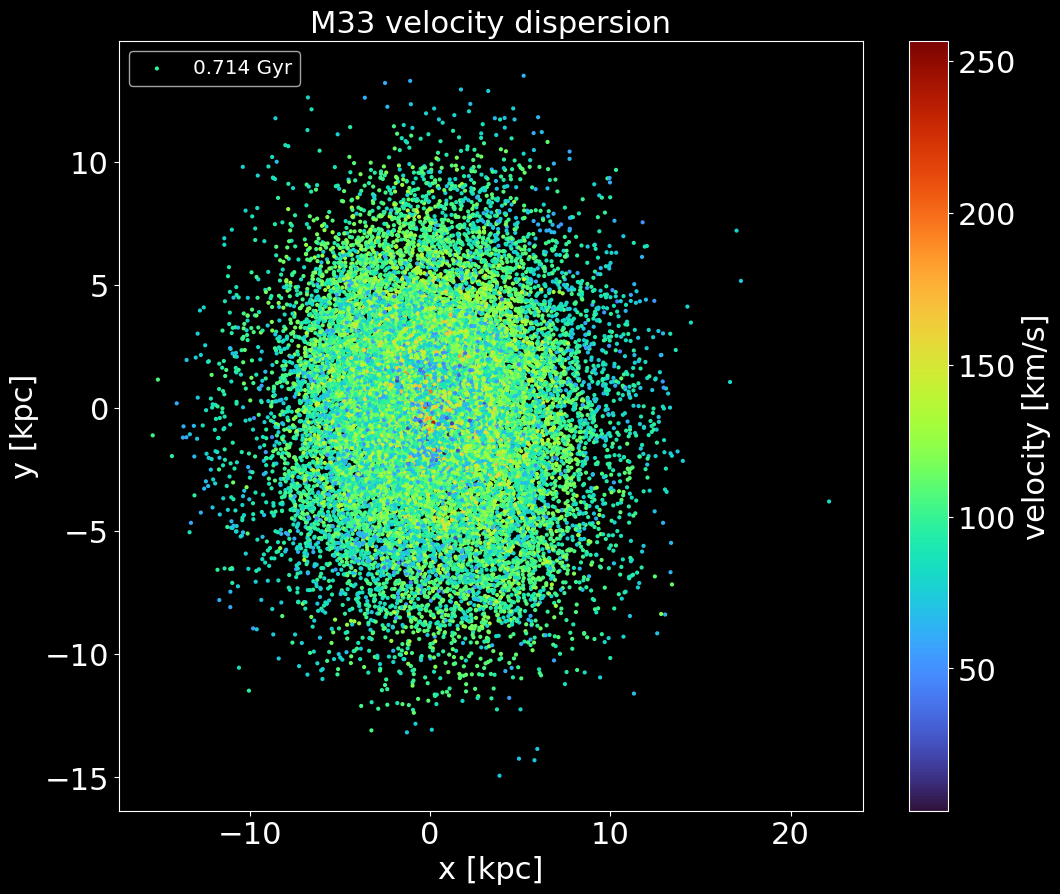

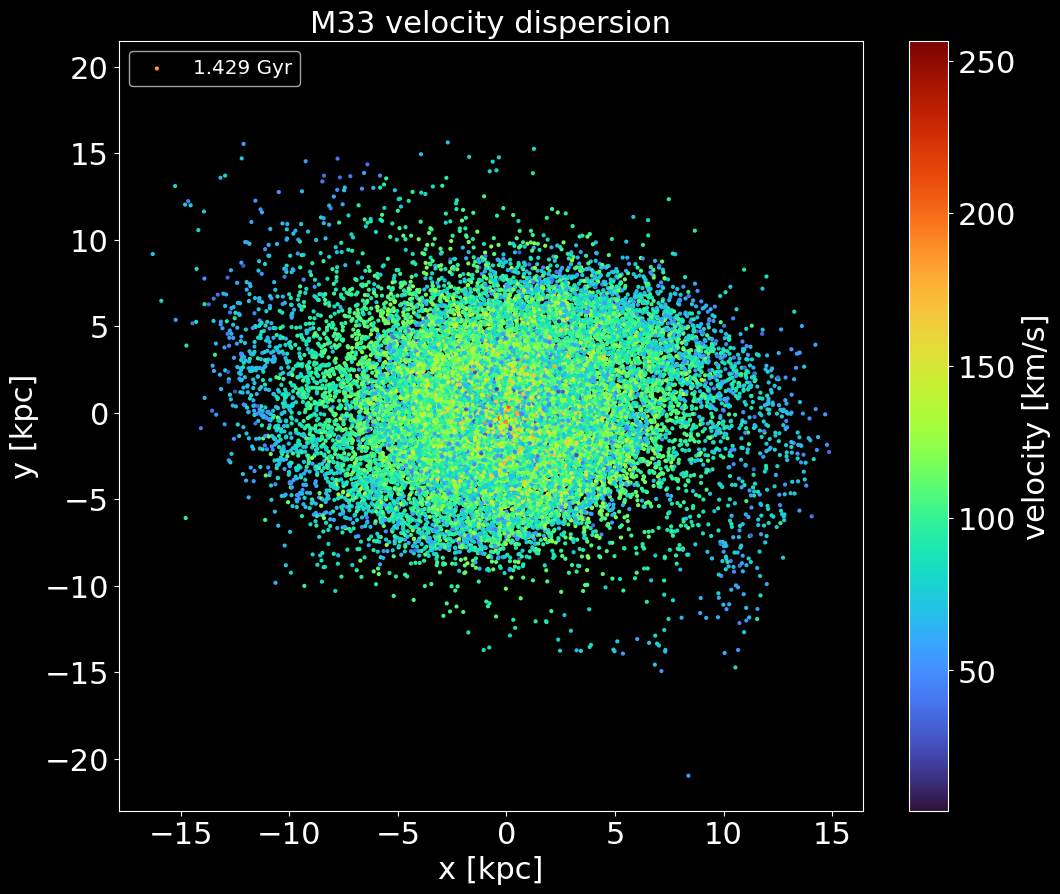

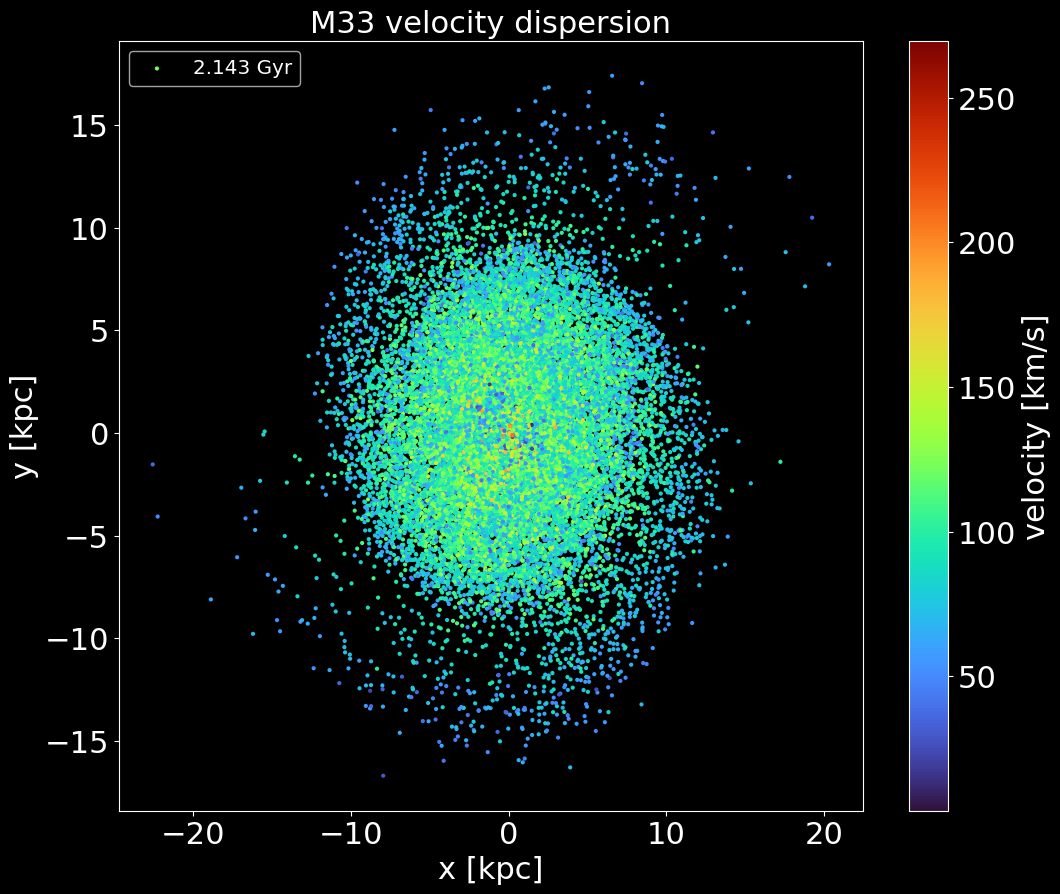

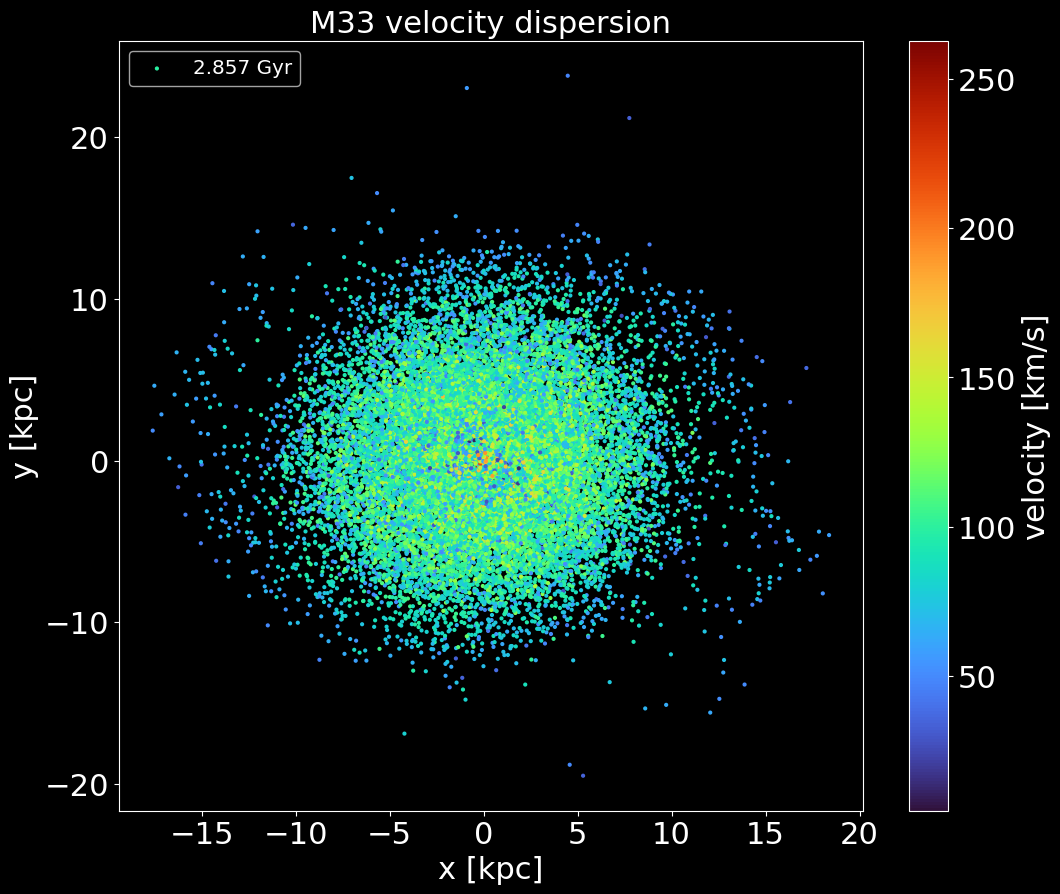

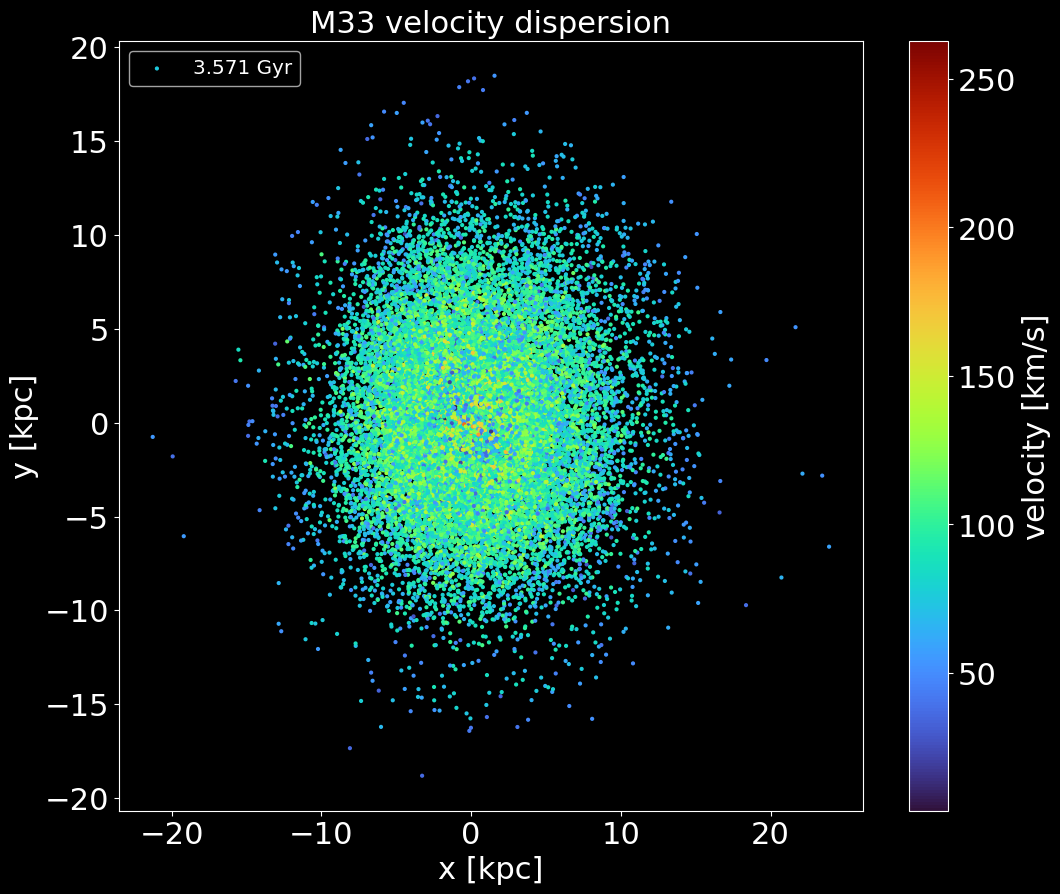

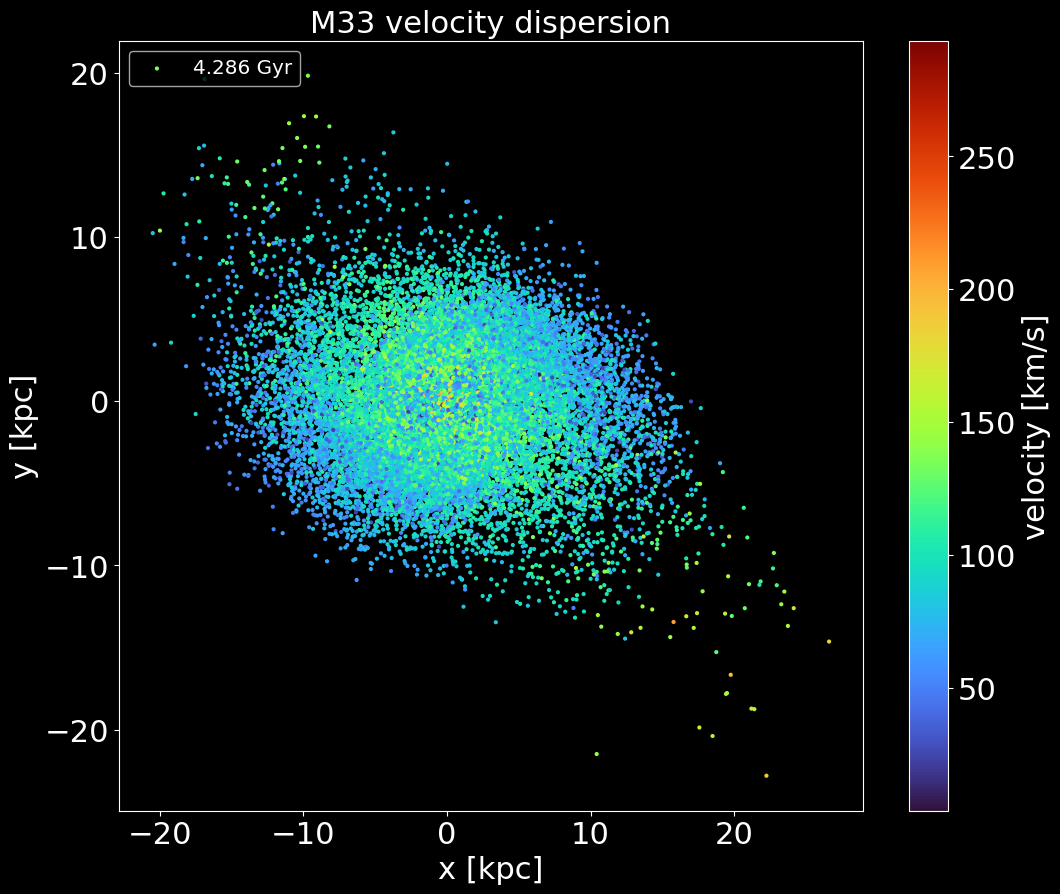

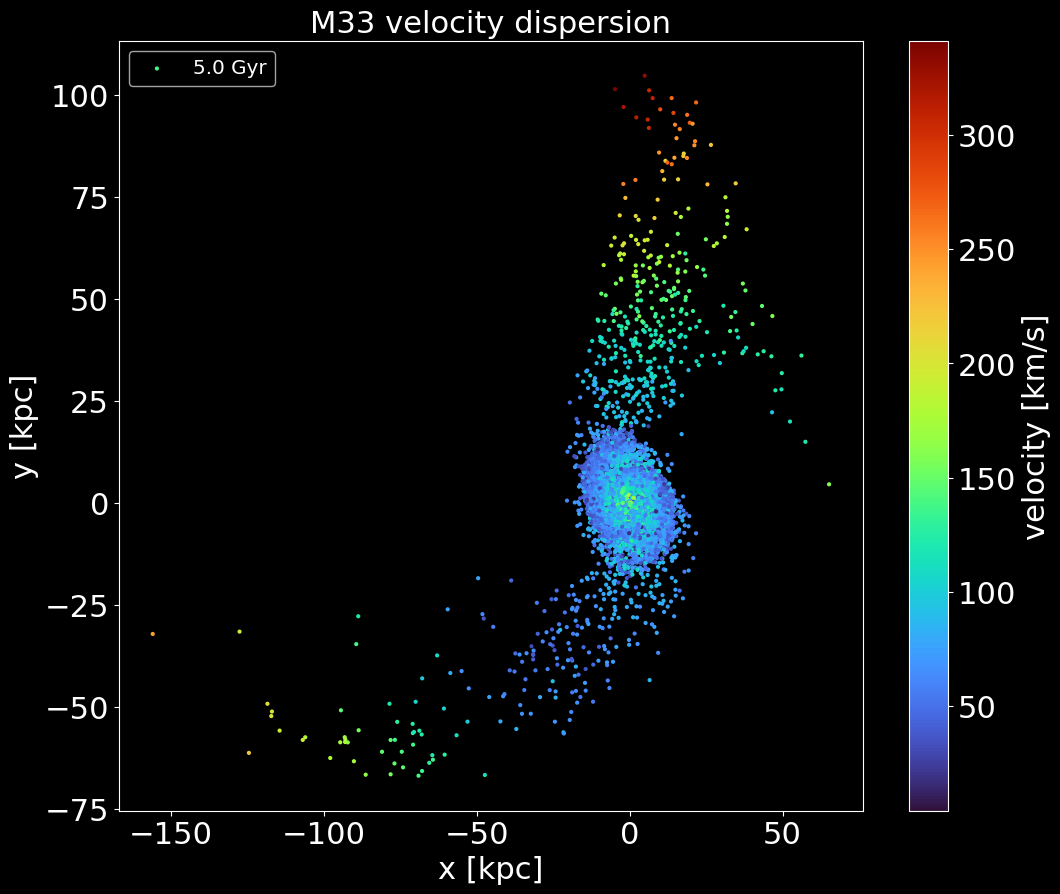

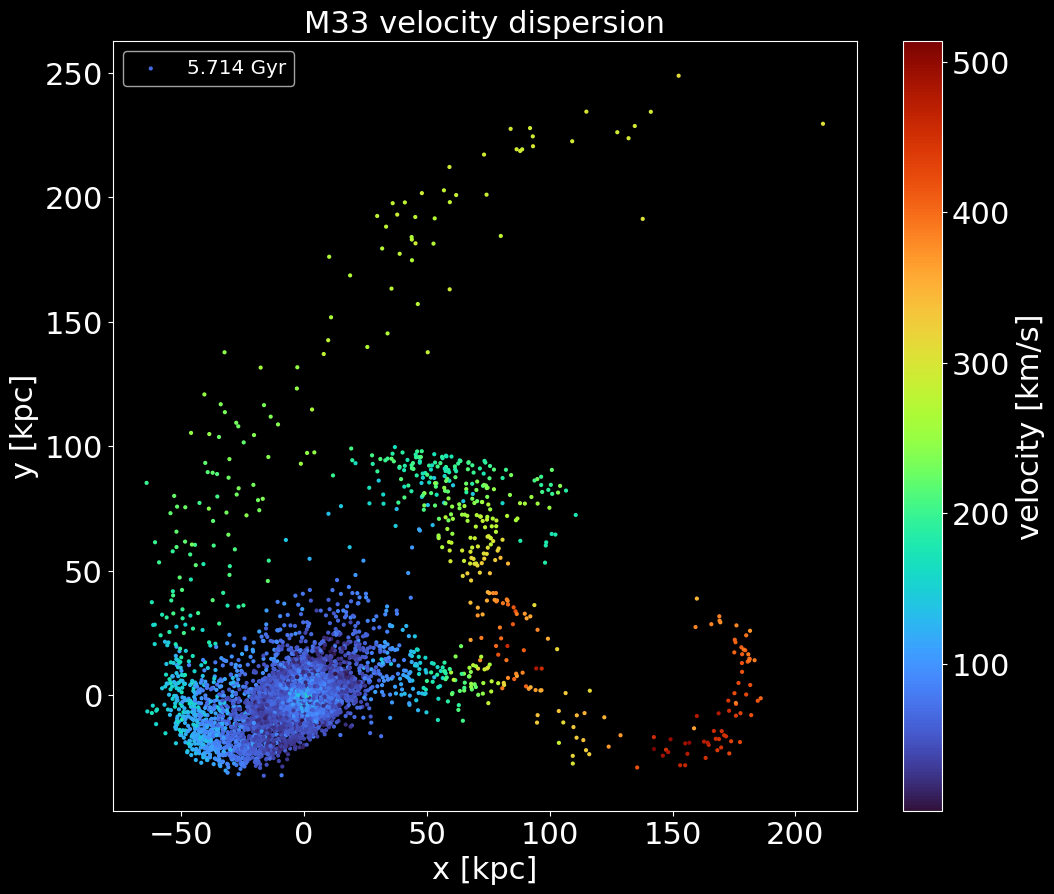

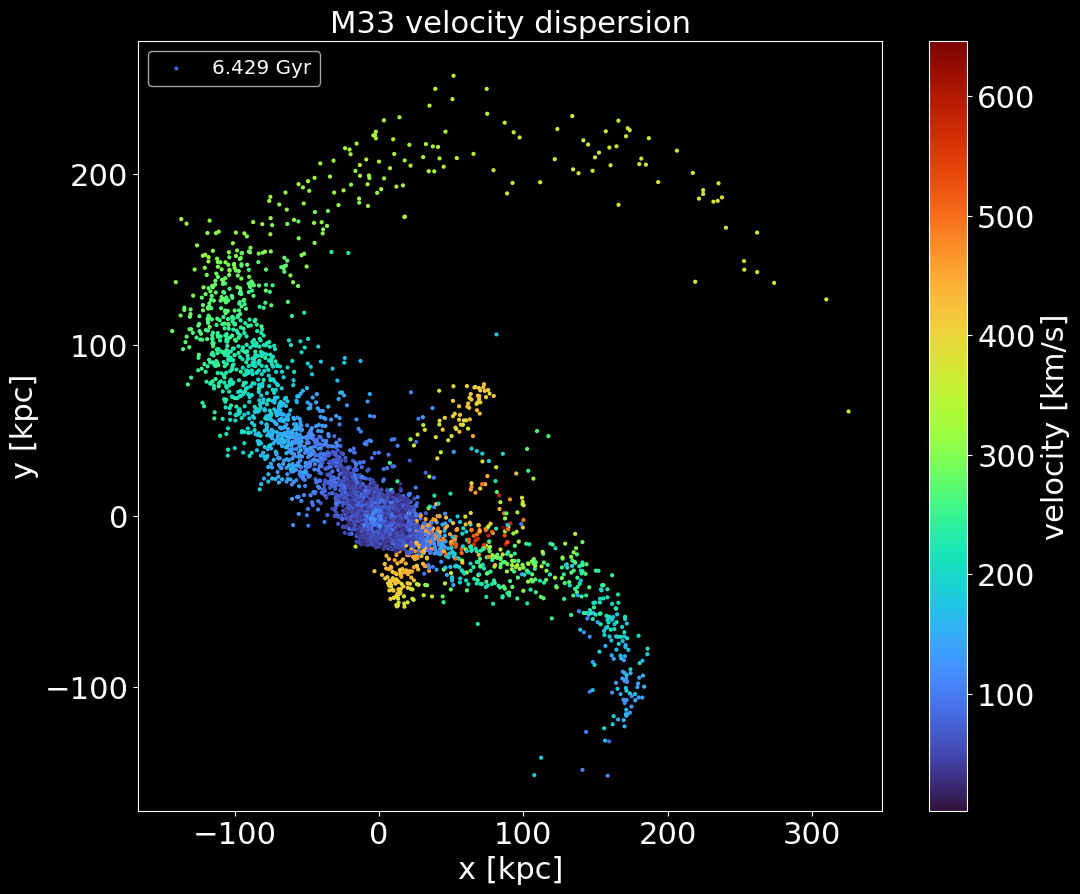

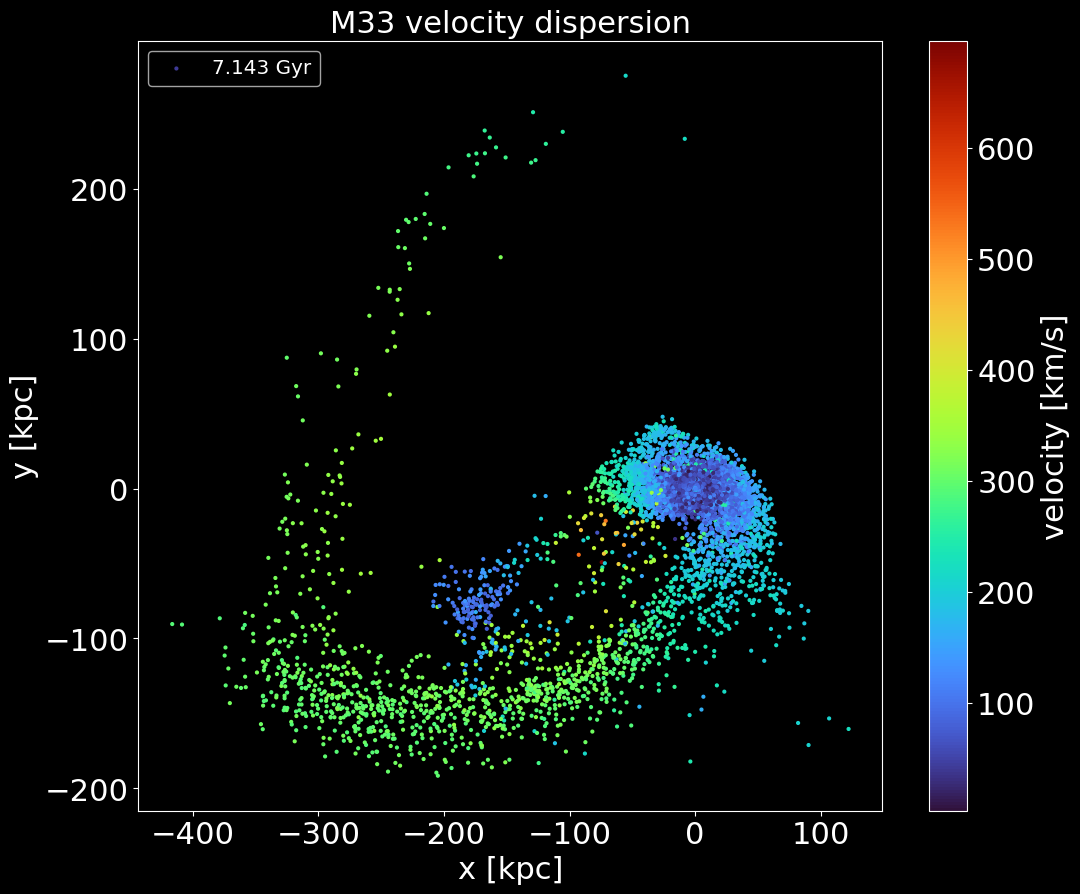

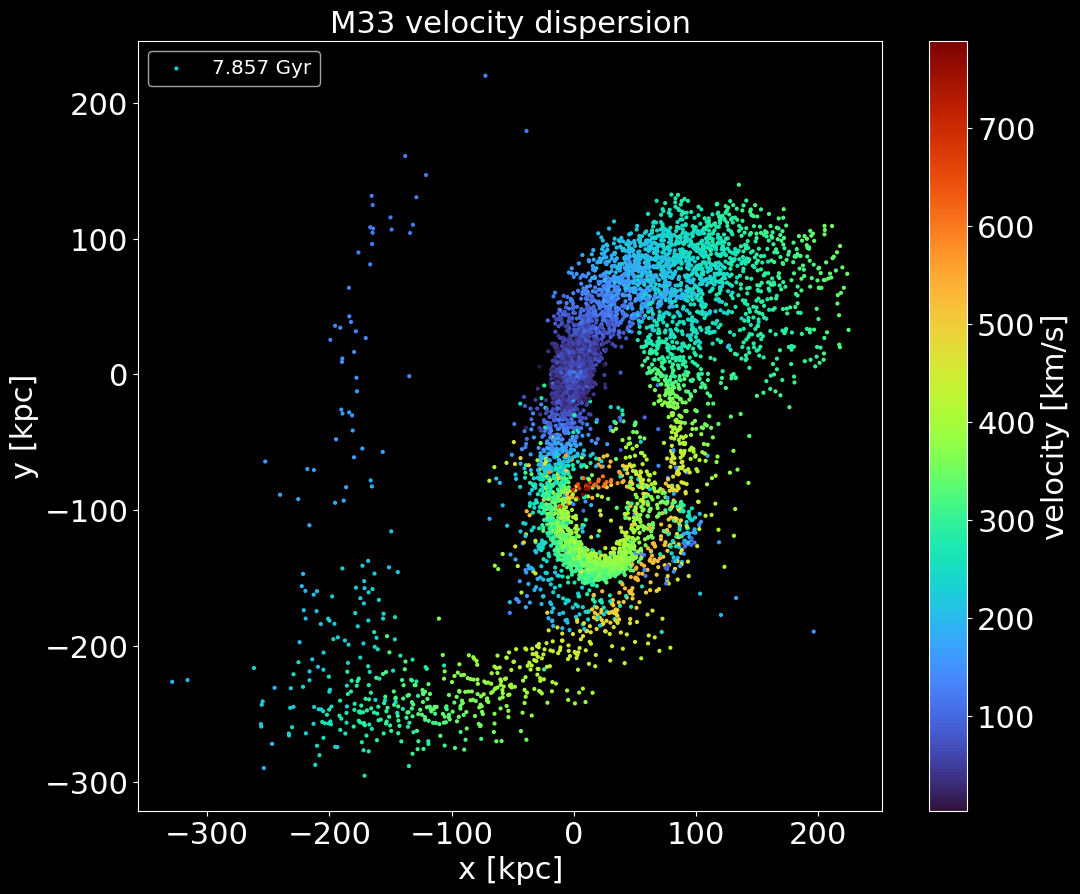

In [623]:
# array of timeteps 
tsteps = np.arange(0,600,50)

for i, step in enumerate(tsteps):# loop over numers in timestep array
    
    # create filename based on corresponding timestep
    if step < 10:
        ilbl = 'M33'+'_00'+str(step)+'.txt'
        ilbl31 = 'M31'+'_00'+str(step)+'.txt'
    elif step >= 10 and step < 100:
        ilbl = 'M33'+'_0'+str(step)+'.txt'
        ilbl31 = 'M31'+'_0'+str(step)+'.txt'
    else:
        ilbl = 'M33'+'_'+str(step)+'.txt'
        ilbl31 = 'M31'+'_'+str(step)+'.txt'

    filename = 'M33'+'/'+ilbl
    M31file = 'M31'+'/'+ilbl31

    # call Positions2D function for positions, velocities, and time
    rn, vn, dist, vel, t = Positions2D(filename)

    #Plotting  code:
    # c=vel colors the particles based on their velocity magnitude
    plt.scatter(rn[:,0], rn[:,1], c=vel, cmap='turbo', s=4, label=f"{np.round(t,3)} Gyr")


    # # plot arrow towards M31 COM
    # COMM33 = CenterOfMass(filename,2)
    # COMP_33 = COMM33.COM_P(0.1,4).value
    # COMM31 = CenterOfMass(M31file,2)
    # COMP_31 = COMM33.COM_P(0.1,2).value
    
    # plt.arrow(0+200, 0+200, COMP_31[0]-COMP_33[0], COMP_31[1]-COMP_33[1], head_width=10, head_length=25, fc='red', ec='red', label='arrow to M31 COM')

    cbar = plt.colorbar()
    cbar.set_label("velocity [km/s]", fontsize=22)
    
    #Add axis labels
    plt.xlabel('x [kpc]', fontsize=22)
    plt.ylabel('y [kpc]', fontsize=22)
    
    plt.legend(loc='upper left',fontsize='x-large')
    plt.title('M33 velocity dispersion',fontsize=22)

    # # #set axis limits
    # plt.ylim(-250,250)
    # plt.xlim(-350,350)
    
    #adjust tick label font size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size

    # Save file
    # plt.savefig('0'+str(i)+'.png')

    plt.show()



# Step 3: plot Jacobi radius over 2D M33 velocity dispersion plots

We are insterested in the stellar streams, which will exist at a distance of or above the Jacobi radius
\begin{equation}
    R_j = r  \bigg( \frac{M_{sat}}{2 M_{host}(<r)} \bigg)^{1/3}
\end{equation}

In [387]:
def JacobiR(Mhost, Msat, r):
    '''
    Function that computes the Jacobi radius of a
    satellite around a host galaxy.
    INPUTS:
        Mhost = 'float', mass of host galaxy in solar masses
        Msat = 'float', mass of particles in the galaxy
        r = 'float', distance of particles from the center of host in kpc
    OUTPUTS:
        Rj = 'float', Jacobi radius

    '''
    a = Msat**(1/3) 
    b = (2*Mhost)**(1/3)

    Rj = r*(a/b)

    return Rj
    

In [ ]:
    # masses 
    m33 = 0.196e12 # total mass of M33 (Msat)
    m31 = 2.06e12 # mass of M31 within this radius (Mhost)

    # # distance between M31com and M33com
    # R = COMP_33-COMP_31
    # R_mag = np.sqrt(R[0]**2+R[1]**2+R[2]**2)

    # rj = JacobiR(m31, m33, R_mag)
    # # this will be an array of radii for each particle
    # # at distance dist[i] from M33's center

    # # average Jacobi radius
    # Rj = np.mean(rj).value

    # # plot Jacobi radius

    # # theta = np.linspace(0, 2*np.pi, 100)
    # # center_x = COMP_33[0] #-COMP_31[0]
    # # center_y = COMP_33[1] #-COMP_31[1]
    # # circx = Rj * np.cos(theta) + np.min(xD)
    # # circy = Rj * np.sin(theta) + np.min(yD)
    
    # # plt.plot(circx, circy, linewidth=3, color='magenta')
    # # plt.gca().set_aspect('equal', adjustable='box') # Ensure circle appears as a circle
        



# Step 4: make velocity dispersion plots of stellar streams alone and make v_avg vs time plot

Use lab9 tracking particles code to choose stellar stream particles, where cylindrical radius index is jacobi radius